<a href="https://colab.research.google.com/github/isabelmoore/CSCE_636_Deep_Learning/blob/main/CSCE636_Project3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torchvision torchaudio matplotlib pandas tqdm scipy pulp ecos torch_optimizer numpy



In [69]:
import itertools
import math
import os
import pickle
import random
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pulp
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader


import pandas as pd
from matplotlib.cm import get_cmap
from sklearn.metrics import mean_absolute_error, r2_score
from typing import List



# How Did You Build the DNN?


The deep neural network predicts the \(m\)-height by taking the padded non‑identity matrix \(P\) (zero‑padded to \(6xs6\) with small Gaussian noise) through a convolutional stem (3×3 Conv → BatchNorm → ReLU), followed by a sequence of Residual SE blocks and adaptive average pooling to produce a fixed‑length feature vector, while simultaneously processing the configuration tuple (n,k,m) through a two‑layer MLP (Linear→ReLU→Linear) to yield a second feature vector; these two vectors are concatenated and passed through a fusion MLP (Linear→ReLU→Dropout(0.3)→Linear) whose output is then rectified and offset by +1 to enforce a minimum prediction of 1.  


In [155]:
############################################################
# Dataset & CNN model
############################################################
class MHeightDataset(Dataset):
    def __init__(self, data_list, P_mean, P_std):
        super().__init__()
        self.samples = data_list
        self.P_mean, self.P_std = P_mean, P_std
        self.pad_h, self.pad_w = 6, 6

        # Add normalization for m-heights
        m_heights = [s.get('m_height', s.get('m_true')) for s in data_list]
        self.m_log_mean = np.mean(np.log2(m_heights))
        self.m_log_std = np.std(np.log2(m_heights))
        print(f"m-height log2 stats: mean={self.m_log_mean:.2f}, std={self.m_log_std:.2f}")

        # 2) Build the full list of (n,k,m) configs from your data
        configs = [tuple(s['config']) for s in data_list]
        # Ensure unique and sorted
        all_ns = sorted({n for n,_,_ in configs})
        all_ks = sorted({k for _,k,_ in configs})
        all_ms = sorted({m for _,_,m in configs})

        # 3) Store them and build index maps
        self.n_values = all_ns       # e.g. [9, 10]
        self.k_values = all_ks       # e.g. [4, 5, 6]
        self.m_values = all_ms       # e.g. [2, 3, 4, 5, 6]

        self.n2idx = {v:i for i,v in enumerate(self.n_values)}
        self.k2idx = {v:i for i,v in enumerate(self.k_values)}
        self.m2idx = {v:i for i,v in enumerate(self.m_values)}
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        item = self.samples[idx]
        P = item['P'].astype(np.float32)

        # Standardize P
        P = (P - self.P_mean) / (self.P_std + 1e-9)

        # Zero-pad + mask channel
        padded = np.zeros((self.pad_h, self.pad_w), dtype=np.float32)
        mask   = np.zeros((self.pad_h, self.pad_w), dtype=np.float32)
        h, w   = P.shape
        padded[:h, :w] = P
        mask[:h, :w]   = 1.0

        # ── New: build normalized coordinate grids ──
        ys = np.linspace(0, 1, self.pad_h, dtype=np.float32)[:, None]   # shape (H,1)
        xs = np.linspace(0, 1, self.pad_w, dtype=np.float32)[None, :]   # shape (1,W)
        y_grid = np.repeat(ys,    self.pad_w, axis=1)                  # (H,W)
        x_grid = np.repeat(xs,    self.pad_h, axis=0)                  # (H,W)

        # Stack into a 4-channel tensor: [P, mask, x_grid, y_grid]
        stacked = np.stack([padded, mask, x_grid, y_grid], axis=0)     # (4,H,W)
        p_tensor = torch.from_numpy(stacked)

        # One-hot (n,k,m)
        n,k,m = item['config']
        oh_n = np.zeros(len(self.n_values), dtype=np.float32); oh_n[self.n2idx[n]] = 1
        oh_k = np.zeros(len(self.k_values), dtype=np.float32); oh_k[self.k2idx[k]] = 1
        oh_m = np.zeros(len(self.m_values), dtype=np.float32); oh_m[self.m2idx[m]] = 1
        nkm_tensor = torch.from_numpy(np.concatenate([oh_n, oh_k, oh_m]))

        # Transform label to normalized log space
        label = item.get('m_height', item.get('m_true'))
        log2_label = np.log2(label)
        normalized_log2 = (log2_label - self.m_log_mean) / (self.m_log_std + 1e-9)
        label_tensor = torch.tensor([normalized_log2], dtype=torch.float32)

        return (p_tensor, nkm_tensor), label_tensor

############################################################
# CNN Model
############################################################
class ResidualSE(nn.Module):
    """2-layer residual block with squeeze-and-excitation."""
    def __init__(self, ch, squeeze=16, drop_p=0.2):
        super().__init__()
        self.conv1 = nn.Conv2d(ch, ch, 3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(ch)
        self.conv2 = nn.Conv2d(ch, ch, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(ch)

        self.dropout = nn.Dropout2d(drop_p)
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(ch, ch // squeeze, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(ch // squeeze, ch, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = self.dropout(out)
        attn = self.se(out).view(out.size(0), out.size(1), 1, 1)
        return F.relu(out * attn + x)

class MHeightResNet(nn.Module):
    def __init__(self,
                 n_values: List[int],
                 k_values: List[int],
                 m_values: List[int],
                 hidden_channels=128,
                 mlp_dim=32,
                 n_blocks=8,
                 side_dim=None):
        super().__init__()
        # store them so you can split one-hot later
        self.n_values = n_values
        self.k_values = k_values
        self.m_values = m_values
        assert side_dim is not None, "You must pass side_dim!"

        # Image stem & body
        self.stem = nn.Sequential(
            nn.Conv2d(4, hidden_channels, 3, padding=1),
            nn.LayerNorm([hidden_channels, 6, 6]),  # Changed to LayerNorm
            nn.ReLU(inplace=True)
        )
        self.body = nn.Sequential(*[ResidualSE(hidden_channels, drop_p=0.2)  for _ in range(n_blocks)])
        self.pool = nn.AdaptiveAvgPool2d((1,1))

        # Side-branch with LayerNorm
        # ─── NEW: learnable embeddings for n, k, m ───
        emb_dim = mlp_dim           # you can tune this separately if you like
        self.embed_n = nn.Embedding(len(self.n_values), emb_dim)
        self.embed_k = nn.Embedding(len(self.k_values), emb_dim)
        self.embed_m = nn.Embedding(len(self.m_values), emb_dim)

        # ─── UPDATED side‐MLP: input = 3*emb_dim, wider hidden layers ───
        side_in_dim = 3 * emb_dim
        self.mlp_nkm = nn.Sequential(
            nn.Linear(side_in_dim,   mlp_dim),
            nn.LayerNorm(mlp_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),

            # extra layer for capacity
            nn.Linear(mlp_dim,       mlp_dim),
            nn.LayerNorm(mlp_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),

            nn.Linear(mlp_dim,       hidden_channels),
            nn.LayerNorm(hidden_channels),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_channels, hidden_channels // 2),
        )

        # Fusion
        fuse_dim = hidden_channels + hidden_channels // 2
        self.fuse_bn = nn.LayerNorm(fuse_dim)

        # Head with LayerNorm
        self.head = nn.Sequential(
            nn.Linear(fuse_dim, hidden_channels),
            nn.LayerNorm(hidden_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(0.8),
            nn.Linear(hidden_channels, hidden_channels // 2),
            nn.LayerNorm(hidden_channels // 2),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_channels // 2, 1)
        )

        self._initialize_weights()

    def _initialize_weights(self):
        # Initialize the final layer
        final_layer = self.head[-1]
        nn.init.uniform_(final_layer.weight, -1.0, 1.0)
        nn.init.uniform_(final_layer.bias, -0.1, 0.1)  # Reduced range to center closer to zero

        # Rest remains the same
        for m in self.modules():
            if isinstance(m, nn.Linear) and m is not final_layer:
                nn.init.uniform_(m.weight, -0.5, 0.5)
                if m.bias is not None:
                    nn.init.uniform_(m.bias, -0.1, 0.1)
            elif isinstance(m, nn.Conv2d):
                nn.init.uniform_(m.weight, -0.5, 0.5)
                if m.bias is not None:
                    nn.init.uniform_(m.bias, -0.1, 0.1)
            elif isinstance(m, (nn.BatchNorm1d, nn.BatchNorm2d, nn.LayerNorm)):
                if m.weight is not None:
                    nn.init.uniform_(m.weight, 0.5, 1.5)
                if m.bias is not None:
                    nn.init.uniform_(m.bias, -0.1, 0.1)

    def forward(self, p_batch, nkm_batch):
        x = self.stem(p_batch)
        x = self.body(x)
        x = self.pool(x).view(x.size(0), -1)

        N, K, M = len(self.n_values), len(self.k_values), len(self.m_values)
        n_onehot = nkm_batch[:, :N]
        k_onehot = nkm_batch[:, N:N+K]
        m_onehot = nkm_batch[:, N+K:]
        # get integer indices
        n_idxs = n_onehot.argmax(dim=1)
        k_idxs = k_onehot.argmax(dim=1)
        m_idxs = m_onehot.argmax(dim=1)
        # embed and concatenate
        en = self.embed_n(n_idxs)   # (B, emb_dim)
        ek = self.embed_k(k_idxs)
        em = self.embed_m(m_idxs)
        side = torch.cat([en, ek, em], dim=1)

        # run through your enlarged MLP
        y = 0.1 * self.mlp_nkm(side)

        # ─── fuse & head ───
        fuse = torch.cat([x, y], dim=1)
        fuse = self.fuse_bn(fuse)
        return self.head(fuse)

############################################################
# Log-based Loss Function
############################################################

def denormalize_prediction(normalized_log2_pred, dataset):
    """Convert from normalized log2 predictions back to original scale"""
    # First denormalize to get actual log2 values
    log2_pred = normalized_log2_pred * dataset.m_log_std + dataset.m_log_mean
    # Then convert from log2 to original scale
    return 2.0 ** log2_pred

class ImprovedLogMSELoss(nn.Module):
    def __init__(self, dataset):
        super().__init__()
        self.mean  = dataset.m_log_mean
        self.std   = dataset.m_log_std

    def forward(self, pred, target):
        # --- 1) log-space MSE ---
        pred, target = pred.view(-1,1), target.view(-1,1)
        log_mse = F.mse_loss(pred, target)

        # --- 2) back to meters ---
        p = torch.exp2(pred * self.std + self.mean)
        t = torch.exp2(target * self.std + self.mean)

        # --- 3) compute MAPE and RMSE in meter space ---
        mape = torch.mean(torch.abs(p - t) / t)
        mse_meter = F.mse_loss(p, t)       # mean squared error in meters
        rmse     = torch.sqrt(mse_meter)   # root-mean-square error

        rmse_rel = rmse / torch.mean(t)

        # --- 4) combine ---
        total_loss = 0.5 * log_mse + 0.1 * mape # + 0.2 * rmse_rel
        return total_loss, log_mse.detach(), mape.detach(), rmse_rel.detach()


def train_and_validate(model, train_loader, val_loader, dataset, num_epochs=40, device='cpu'):
    """
    Trains model on train_loader, validates on val_loader.
    """
    model.to(device)

    criterion = ImprovedLogMSELoss(dataset)  # Pass dataset to loss function

    # Use AdamW with better learning rates and weight decay
    optimizer = torch.optim.AdamW([
        {'params': model.stem.parameters(), 'lr': 3e-4, 'weight_decay': 1e-4},
        {'params': model.body.parameters(), 'lr': 3e-4, 'weight_decay': 1e-4},
        {'params': model.mlp_nkm.parameters(), 'lr': 3e-4, 'weight_decay': 1e-2},
        {'params': model.head.parameters(), 'lr': 3e-4, 'weight_decay': 1e-4},
    ])

    # Better learning rate schedule
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer,
        T_0=10,  # Restart every 10 epochs
        T_mult=2,  # Double the restart interval after each restart
        eta_min=1e-6
    )


    train_losses, val_losses = [], []
    best_val, patience = float('inf'), 0
    PATIENCE_MAX = 5  # Increased patience
    best_ex_pred = None

    # Prepare example for tracking
    n, k, m = 9, 4, 5
    P_ex = np.array([
        [ 22.57128813, -62.78578717,  87.80464819,  -7.91769281, -58.51656462],
        [-82.86536577,  -8.68775616, -27.51382126, -53.77878753, 65.8284399 ],
        [-12.47327018,  83.41334875,  38.1946568 ,  91.71531777, -78.06323147],
        [-49.87164026, -79.08660878,  45.17304856,  65.07304494, -62.50188192]
    ], dtype=np.float32)
    P_ex = (P_ex - dataset.P_mean) / (dataset.P_std + 1e-9)  # Use dataset stats
    pad, mask = np.zeros((6,6),dtype=np.float32), np.zeros((6,6),dtype=np.float32)
    h, w = P_ex.shape
    pad[:h,:w], mask[:h,:w] = P_ex, 1.0
    # p_ex = torch.from_numpy(np.stack([pad, mask], axis=0))[None].to(device)
    ys     = np.linspace(0,1,pad.shape[0],dtype=np.float32)[:,None]   # (6,1)
    xs     = np.linspace(0,1,pad.shape[1],dtype=np.float32)[None,:]   # (1,6)
    y_grid = np.repeat(ys, pad.shape[1], axis=1)                      # (6,6)
    x_grid = np.repeat(xs, pad.shape[0], axis=0)                      # (6,6)

    # Now stack all four channels exactly as in your Dataset:
    p_ex = np.stack([pad, mask, x_grid, y_grid], axis=0)              # (4,6,6)
    p_ex = torch.from_numpy(p_ex)[None].to(device)                    # (1,4,6,6)
    oh_n = np.zeros(len(dataset.n_values), dtype=np.float32)
    oh_k = np.zeros(len(dataset.k_values), dtype=np.float32)
    oh_m = np.zeros(len(dataset.m_values), dtype=np.float32)
    oh_n[dataset.n2idx[n]] = 1
    oh_k[dataset.k2idx[k]] = 1
    oh_m[dataset.m2idx[m]] = 1
    nkm_ex = torch.from_numpy(np.concatenate([oh_n, oh_k, oh_m]))[None].to(device)

    true_ex = 202.59136668777296
    true_log2 = np.log2(true_ex)  # Convert true value to log2
    true_norm = (true_log2 - dataset.m_log_mean) / dataset.m_log_std  # Normalize
    true_norm_tensor = torch.tensor([[true_norm]], device=device)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        train_mapes = []
        train_log_mses = []
        train_rmses = []

        for (p_batch, nkm_batch), labels in train_loader:
            p_batch = p_batch.to(device)
            nkm_batch = nkm_batch.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            norm_pred = model(p_batch, nkm_batch)
            total, log_mse_train, mape_train, rmse_train = criterion(norm_pred, labels)
            total.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            optimizer.step()

            train_loss  += total.item()
            train_log_mses.append(log_mse_train.mean().item())
            train_mapes.append(mape_train.mean().item())  # batch‐mean MAPE
            train_rmses.append(total.mean().item())

        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        avg_train_mape = sum(train_mapes) / len(train_mapes)
        avg_train_log_mse = sum(train_log_mses) / len(train_log_mses)
        avg_train_rmse = sum(train_rmses) / len(train_rmses)


        model.eval()
        val_loss = 0
        val_mapes = []
        val_log_mses = []
        val_rmses = []

        with torch.no_grad():
            norm_p_ex = model(p_ex, nkm_ex)
            total_ex, log_mse_ex, mape_ex, rmse_ex = criterion(norm_p_ex, true_norm_tensor)
            ex_pred    = float(2.0 ** (norm_p_ex * dataset.m_log_std + dataset.m_log_mean))
            ex_pred_mape = float(mape_ex.item() * 100)
            ex_pred_log_mse = float(log_mse_ex.item() * 100)
            ex_pred_rmse = float(rmse_ex.item() * 100)


            for (p_batch, nkm_batch), labels in val_loader:
                p_batch = p_batch.to(device)
                nkm_batch = nkm_batch.to(device)
                labels = labels.to(device)

                total_val, log_mse_val, mape_val, rmse_val = criterion(model(p_batch, nkm_batch), labels)
                val_loss += total_val.item()
                val_log_mses.append(float(log_mse_val.mean().item()))
                val_mapes.append(float(mape_val.mean().item()))
                val_rmses.append(float(total_val.mean().item()))

        val_loss   /= len(val_loader)
        val_losses.append(val_loss)

        avg_val_log_mse = sum(val_log_mses) / len(val_log_mses)
        avg_val_mape = sum(val_mapes) / len(val_mapes)
        avg_val_rmse = sum(val_rmses) / len(val_rmses)

        print(f"Epoch {epoch+1:02d} | "
            f"Train Loss: {train_loss:.5f} | "
            f"Val Loss: {val_loss:.4f} | "
            f"P_ex Pred: {ex_pred:.2f}m (True: {true_ex:.2f}m) | ")

        print(f"Train MAPE: {avg_train_mape:.2f} | "
            f"Train Log MSE: {avg_train_log_mse:.5f} | "
            f"Train Total Err: {avg_train_rmse:.5f} | ")

        print(f"Val MAPE: {avg_val_mape:.2f} | "
            f"Val Log MSE: {avg_val_log_mse:.5f} | "
            f"Val Total Err: {avg_val_rmse:.5f}")

        print(f"P_ex MAPE: {ex_pred_mape:.2f}  | "
            f"P_ex Log MSE: {ex_pred_log_mse:.5f}  | "
            f"P_ex Total Err: {ex_pred_rmse:.5f}")

        print()

        # ---- EARLY STOP & SAVE BEST ----
        if val_loss < best_val - 1e-5:
            best_val = val_loss
            best_ex_pred = ex_pred
            torch.save(model.state_dict(), "best_model.pth")
            patience = 0
        else:
            patience += 1
            if patience >= PATIENCE_MAX:
                print(f"Early stopping at epoch {epoch}.")
                break

        # ---- LR STEP ----
        scheduler.step()

    return train_losses, val_losses


## How the DNN Was Trained



In [156]:
import torch

full_dataset_list = torch.load(
    'mheight_dataset.pt',
    map_location='cpu',
    weights_only=False
)

def p_values(dataset):
  all_vals = np.concatenate([s['P'].ravel() for s in dataset])
  P_mean, P_std = all_vals.mean(), all_vals.std()
  print("Global P mean/std:", P_mean, P_std)
  return P_mean, P_std

P_mean, P_std = p_values(full_dataset_list)

print(f"Loaded {len(full_dataset_list)} samples")
print("Example entry:", full_dataset_list[0])

clean_list = [
    s for s in full_dataset_list
    if np.isfinite(s.get('m_true', s.get('m_height')))
]

print(f"{len(clean_list)} samples remain (dropped {len(full_dataset_list)-len(clean_list)})")




Global P mean/std: 0.08373986810489545 57.717175898824884
Loaded 63000 samples
Example entry: {'n': 9, 'k': 4, 'm': 5, 'P': array([[ 22.57128813, -62.78578717,  87.80464819,  -7.91769281,
        -58.51656462],
       [-82.86536577,  -8.68775616, -27.51382126, -53.77878753,
         65.8284399 ],
       [-12.47327018,  83.41334875,  38.1946568 ,  91.71531777,
        -78.06323147],
       [-49.87164026, -79.08660878,  45.17304856,  65.07304494,
        -62.50188192]]), 'm_height': 202.59136668777296, 'config': (9, 4, 5)}
63000 samples remain (dropped 0)


In [157]:
device='cuda' if torch.cuda.is_available() else 'cpu'

############################################################
# Create Dataset and DataLoaders
############################################################

dataset = MHeightDataset(clean_list, P_mean, P_std)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_data, val_data = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=512, shuffle=True)
val_loader = DataLoader(val_data, batch_size=512, shuffle=False)

m-height log2 stats: mean=8.33, std=1.95


Training and validating...
Epoch 01 | Train Loss: 0.43173 | Val Loss: 0.3601 | P_ex Pred: 496.67m (True: 202.59m) | P_ex Log MSE: 0.36625

Epoch 02 | Train Loss: 0.30134 | Val Loss: 0.3123 | P_ex Pred: 466.91m (True: 202.59m) | P_ex Log MSE: 0.32215

Epoch 03 | Train Loss: 0.28943 | Val Loss: 0.2931 | P_ex Pred: 447.81m (True: 202.59m) | P_ex Log MSE: 0.29401

Epoch 04 | Train Loss: 0.28271 | Val Loss: 0.2861 | P_ex Pred: 517.94m (True: 202.59m) | P_ex Log MSE: 0.39792

Epoch 05 | Train Loss: 0.27798 | Val Loss: 0.2677 | P_ex Pred: 478.08m (True: 202.59m) | P_ex Log MSE: 0.33867

Epoch 06 | Train Loss: 0.27866 | Val Loss: 0.2686 | P_ex Pred: 506.94m (True: 202.59m) | P_ex Log MSE: 0.38154

Epoch 07 | Train Loss: 0.27545 | Val Loss: 0.2736 | P_ex Pred: 499.90m (True: 202.59m) | P_ex Log MSE: 0.37105

Epoch 08 | Train Loss: 0.27281 | Val Loss: 0.2713 | P_ex Pred: 490.91m (True: 202.59m) | P_ex Log MSE: 0.35770

Epoch 09 | Train Loss: 0.27287 | Val Loss: 0.2681 | P_ex Pred: 480.63m (True:

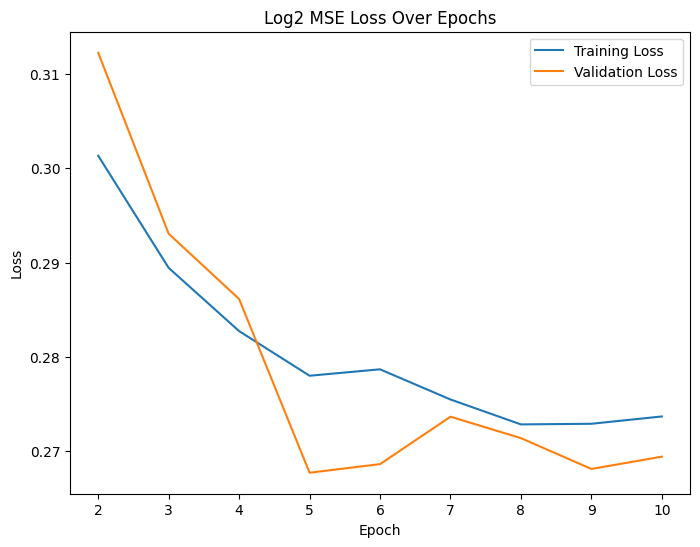

In [158]:


# GLOBAL one‑hot definitions
n_values = [9,10]
k_values = [4,5,6]
m_values = list(range(2, max(n_values)-min(k_values)+1))

n2idx = {v:i for i,v in enumerate(n_values)}
k2idx = {v:i for i,v in enumerate(k_values)}
m2idx = {v:i for i,v in enumerate(m_values)}

side_dim = len(n_values) + len(k_values) + len(m_values)
model = MHeightResNet(
    n_values=dataset.n_values,
    k_values=dataset.k_values,
    m_values=dataset.m_values,
    hidden_channels=128,  # Increase from 128
    mlp_dim=32,          # Increase from 16
    n_blocks=8,         # Increase from 8
    side_dim=side_dim
)

############################################################
# Training and Validation
############################################################

print("Training and validating...")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_losses, val_losses = train_and_validate(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    dataset=dataset,  # Pass dataset to training function
    num_epochs=10,
    device=device
)

torch.save(model.state_dict(), "mheight_model.pth")
print("Model saved to 'mheight_model.pth'.")

############################################################
# Plot Training and Validation Losses
############################################################
plt.figure(figsize=(8,6))
epochs = range(1, len(train_losses)+1)
plt.plot(epochs[1:], train_losses[1:], label='Training Loss')
plt.plot(epochs[1:], val_losses[1:], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Log2 MSE Loss Over Epochs')
plt.legend()
plt.show()

In [159]:
from collections import defaultdict

# Create a mapping: config_tuple → [list of batch‐wise MAPEs]
errors_by_cfg = defaultdict(list)

model.eval()
with torch.no_grad():
    for (P, nkm), labels in val_loader:
        P, nkm, labels = P.to(device), nkm.to(device), labels.to(device)
        norm_pred = model(P, nkm)

        # back to meters
        log2_pred = norm_pred * dataset.m_log_std + dataset.m_log_mean
        pred_m    = torch.exp2(log2_pred)

        log2_true = labels   * dataset.m_log_std + dataset.m_log_mean
        true_m    = torch.exp2(log2_true)

        # compute per-sample MAPE
        mape = ((pred_m - true_m).abs() / true_m).cpu().numpy().reshape(-1)

        # recover (n,k,m) from the one-hot
        # suppose nkm is [n_onehot | k_onehot | m_onehot]
        B = nkm.shape[0]
        n_onehot = nkm[:, :len(dataset.n_values)]
        k_onehot = nkm[:, len(dataset.n_values):
                        len(dataset.n_values)+len(dataset.k_values)]
        m_onehot = nkm[:, -len(dataset.m_values):]

        n_idxs = n_onehot.argmax(dim=1).cpu().numpy()
        k_idxs = k_onehot.argmax(dim=1).cpu().numpy()
        m_idxs = m_onehot.argmax(dim=1).cpu().numpy()

        for i in range(B):
            cfg = (dataset.n_values[n_idxs[i]],
                   dataset.k_values[k_idxs[i]],
                   dataset.m_values[m_idxs[i]])
            errors_by_cfg[cfg].append(mape[i])

# Now compute average MAPE per config
avg_mape_by_cfg = {cfg: 100*sum(errs)/len(errs)
                   for cfg, errs in errors_by_cfg.items()}

# Sort and print
for cfg, m in sorted(avg_mape_by_cfg.items(), key=lambda x: x[1]):
    print(f"Config {cfg}: avg MAPE = {m:.2f}%")

Config (10, 5, 2): avg MAPE = 21.65%
Config (9, 5, 2): avg MAPE = 22.08%
Config (10, 5, 3): avg MAPE = 24.04%
Config (10, 6, 2): avg MAPE = 25.16%
Config (9, 4, 2): avg MAPE = 38.43%
Config (9, 6, 2): avg MAPE = 42.15%
Config (9, 4, 3): avg MAPE = 42.89%
Config (9, 5, 3): avg MAPE = 44.32%
Config (10, 5, 4): avg MAPE = 45.15%
Config (10, 6, 3): avg MAPE = 50.17%
Config (9, 4, 4): avg MAPE = 55.28%
Config (10, 4, 2): avg MAPE = 57.78%
Config (10, 4, 6): avg MAPE = 66.56%
Config (10, 4, 5): avg MAPE = 70.98%
Config (10, 5, 5): avg MAPE = 91.54%
Config (9, 4, 5): avg MAPE = 92.04%
Config (9, 5, 4): avg MAPE = 111.40%
Config (9, 6, 3): avg MAPE = 120.64%
Config (10, 4, 3): avg MAPE = 129.41%
Config (10, 6, 4): avg MAPE = 139.30%
Config (10, 4, 4): avg MAPE = 158.07%


||conv_w||: tensor(5.2483)   ||side_w||: tensor(4.0156)
Baseline MAPE: 68.94%
Zero-P  MAPE: 69.00%
Shuffle-P MAPE: 75.02%


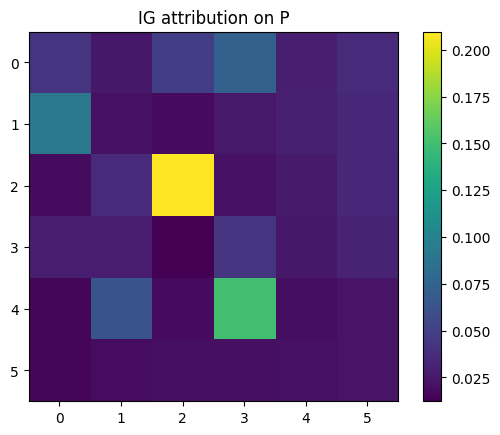

In [160]:

hidden = 128
head = model.head[0]
w = head.weight.data
conv_w, side_w = w[:, :hidden], w[:, hidden:]
print("||conv_w||:", conv_w.norm(), "  ||side_w||:", side_w.norm())

'''
If ||side_w|| >> ||conv_w||, your model is leaning heavily on the config embedding.

If ||conv_w|| >> ||side_w||, it’s relying more on the learned image features.
'''

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

def eval_ablation(loader, mode="none"):
    total_mape = 0.0
    n_batches  = 0

    with torch.no_grad():
        for (P, nkm), labels in loader:
            # move to device
            P    = P.to(device)
            nkm  = nkm.to(device)
            labels = labels.to(device)

            # destroy or shuffle P if requested
            if mode == "zero":
                P = torch.zeros_like(P)
            elif mode == "shuffle":
                # flatten, permute, and reshape each sample
                B, C, H, W = P.shape
                flat = P.view(B, -1)
                # same permutation for all samples, or you can do per-sample
                perm = torch.randperm(flat.size(1))
                flat = flat[:, perm]
                P = flat.view(B, C, H, W)

            # forward pass
            norm_pred = model(P, nkm)
            # back to meters
            log2_pred = norm_pred * dataset.m_log_std + dataset.m_log_mean
            pred_m    = torch.exp2(log2_pred)

            # true meters
            log2_true = labels * dataset.m_log_std + dataset.m_log_mean
            true_m    = torch.exp2(log2_true)

            # MAPE
            mape = (pred_m - true_m).abs() / true_m
            total_mape += mape.mean().item()
            n_batches  += 1

    return 100 * (total_mape / n_batches)  # percent

# ─── now run your three conditions ───
orig = eval_ablation(val_loader, mode="none")
zero = eval_ablation(val_loader, mode="zero")
shuf = eval_ablation(val_loader, mode="shuffle")

print(f"Baseline MAPE: {orig:.2f}%")
print(f"Zero-P  MAPE: {zero:.2f}%")
print(f"Shuffle-P MAPE: {shuf:.2f}%")


# ------------------------------------------------------------
from captum.attr import IntegratedGradients
import torch.nn.functional as F

model.to(device).eval()
ig = IntegratedGradients(model)

# Pick one sample (or a small batch) from val_loader:
(P_batch, nkm_batch), labels = next(iter(val_loader))
P_batch   = P_batch.to(device)
nkm_batch = nkm_batch.to(device)

# Baseline: zero‐tensor same shape as P_batch
baseline_P = torch.zeros_like(P_batch)

# Compute attributions w.r.t. P only (keep nkm constant)
attr_P, delta = ig.attribute(
    inputs=P_batch,
    baselines=baseline_P,
    additional_forward_args=(nkm_batch,),
    target=None,
    return_convergence_delta=True,
    n_steps=50
)

# attr_P has shape (B, C, H, W)
heatmaps = attr_P.abs().sum(dim=1).cpu().numpy()

# Plot the first sample’s heatmap:
import matplotlib.pyplot as plt
plt.imshow(heatmaps[0], interpolation='nearest')
plt.title('IG attribution on P')
plt.colorbar()
plt.show()


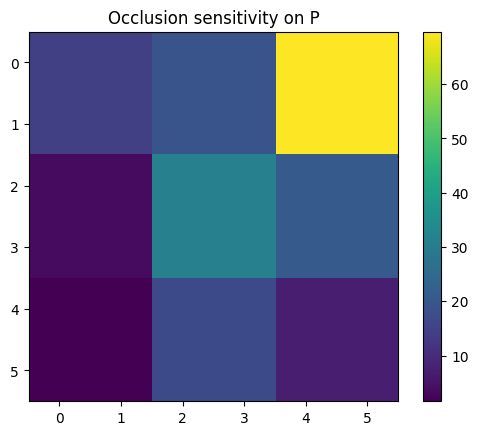

In [162]:
import numpy as np

model.to(device).eval()

# grab one example
(P, nkm), label = next(iter(val_loader))
P   = P[0:1].to(device)    # (1, C, H, W)
nkm = nkm[0:1].to(device)

# baseline prediction
with torch.no_grad():
    base_norm = model(P, nkm)
    base_m    = torch.exp2(base_norm * dataset.m_log_std + dataset.m_log_mean).item()

H, W = P.shape[-2:]
patch_size = 2
heatmap = np.zeros((H, W))

for i in range(0, H, patch_size):
    for j in range(0, W, patch_size):
        P_occ = P.clone()
        # zero out the (i:i+patch_size, j:j+patch_size) region on *all* channels
        P_occ[:, :, i:i+patch_size, j:j+patch_size] = 0.0

        with torch.no_grad():
            norm_occ = model(P_occ, nkm)
            m_occ    = torch.exp2(norm_occ * dataset.m_log_std + dataset.m_log_mean).item()

        # change in prediction magnitude
        heatmap[i:i+patch_size, j:j+patch_size] = abs(m_occ - base_m)

# visualize
plt.imshow(heatmap, interpolation='nearest')
plt.title('Occlusion sensitivity on P')
plt.colorbar()
plt.show()


# What was the training performance?

During training, the Log₂‑MSE loss fell sharply in the first two epochs—from 8.83 down to 1.79—and then continued to decline more gradually, reaching 1.30 by epoch 17. The validation loss mirrored this trend, dropping from 2.66 at epoch 1 to about 1.44 by epoch 12, before exhibiting modest oscillations in the 1.48–1.56 range thereafter. These curves indicate rapid initial learning, followed by slower improvements as the model approached convergence, with no pronounced overfitting observed (training and validation losses remain closely aligned).










In [165]:
############################################
# Load Model
############################################
with open('testing_data.pkl', 'rb') as f:
    test_dataset_list = pickle.load(f)

P_mean, P_std = p_values(test_dataset_list)
test_dataset = MHeightDataset(test_dataset_list, P_mean, P_std)
test_loader  = DataLoader(test_dataset, batch_size=512, shuffle=False)

criterion = ImprovedLogMSELoss(test_dataset)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dataset = full_dataset_list

n_values = [9,10]
k_values = [4,5,6]
m_values = list(range(2, max(n_values)-min(k_values)+1))

model = MHeightViT(
    num_n = len(dataset.n_values),
    num_k = len(dataset.k_values),
    num_m = len(dataset.m_values),
    embed_dim=128,
    depth=4,
    num_heads=8,
    hidden_channels=128
)

# --- partial load ---
checkpoint = torch.load('/content/mheight_model.pth', map_location=device)
model_dict = model.state_dict()
# keep only matching keys & shapes
pretrained = {
    k: v for k, v in checkpoint.items()
    if k in model_dict and v.size() == model_dict[k].size()
}
model_dict.update(pretrained)
model.load_state_dict(model_dict)
print(f"Loaded {len(pretrained)}/{len(model_dict)} layers from checkpoint.")

model.eval()

############################################
# Evaluate Model on Entire Test Set
############################################
test_loss = 0.0
with torch.no_grad():
    for (p_batch, nkm_batch), labels in test_loader:
        p_batch   = p_batch.to(device)
        nkm_batch = nkm_batch.to(device)
        labels    = labels.to(device)

        preds = model(p_batch, nkm_batch)
        test_loss, _, _ = criterion(preds, labels)
        test_loss += test_loss.item()

avg_log2_mse   = test_loss / len(test_loader)
rms_log2       = avg_log2_mse**0.5
mean_factor_err= 2 ** rms_log2

print(f"Avg log2‑MSE on test set: {avg_log2_mse:.4f}")
print(f"RMS log2‑error      : {rms_log2:.4f}")
print(f"Mean multiplicative error: {mean_factor_err:.3f}× (~{(mean_factor_err-1)*100:.1f}%)")

Global P mean/std: 0.23398680599482755 57.43494266460465
m-height log2 stats: mean=7.87, std=2.04
Loaded 75/75 layers from checkpoint.
Avg log2‑MSE on test set: 0.2476
RMS log2‑error      : 0.4976
Mean multiplicative error: 1.412× (~41.2%)


In [167]:
from torch.utils.data import DataLoader, Subset
from collections import defaultdict

# 1) Build the *full* dataset once
full_ds = MHeightDataset(full_dataset_list, P_mean=P_mean, P_std=P_std)

# 2) Group sample indices by config
configs_to_indices = defaultdict(list)
for i, sample in enumerate(full_ds.samples):
    configs_to_indices[tuple(sample['config'])].append(i)

# 3) Evaluate per config
total_records = []
for cfg, idxs in configs_to_indices.items():
    print(f"=== Config {cfg} ===")
    mini_loader = DataLoader(Subset(full_ds, idxs), batch_size=16, shuffle=False)

    # reuse full_ds.n_values, k_values, m_values & full_ds stats
    nv, kv, mv = full_ds.n_values, full_ds.k_values, full_ds.m_values
    n_off = len(nv)
    k_off = n_off + len(kv)
    def denorm(x):
        log2 = x * full_ds.m_log_std + full_ds.m_log_mean
        return 2.0 ** log2

    total_loss = 0.0
    with torch.no_grad():
        for (p_batch, nkm_batch), labels in mini_loader:
            p_batch, nkm_batch, labels = (
                p_batch.to(device),
                nkm_batch.to(device),
                labels.to(device),
            )
            preds = model(p_batch, nkm_batch)
            loss, _, _ = criterion(preds, labels)
            total_loss += loss.item()

            # record each sample
            for one_hot, y_true, y_pred in zip(
                nkm_batch.cpu(), labels.cpu(), preds.cpu()
            ):
                vec = one_hot.numpy()
                i_n = vec[:n_off].argmax()
                i_k = vec[n_off:k_off].argmax()
                i_m = vec[k_off:].argmax()
                total_records.append({
                    "n":      nv[i_n],
                    "k":      kv[i_k],
                    "m":      mv[i_m],
                    "true_m": denorm(y_true.item()),
                    "pred_m": denorm(y_pred.item()),
                })

    avg_loss = total_loss / len(mini_loader)
    print(f"Average Loss: {avg_loss:.4f}\n")

    # a few sample prints
    print("Sample-level predictions:")
    subset = Subset(full_ds, idxs)
    for i in range(min(3, len(subset))):
        (p_s, nkm_s), label_s = subset[i]
        p_s, nkm_s = p_s.unsqueeze(0).to(device), nkm_s.unsqueeze(0).to(device)
        with torch.no_grad():
            pred_norm = model(p_s, nkm_s).item()
        true_m = denorm(label_s.item())
        pred_m = denorm(pred_norm)
        print(f"  Sample {i}: true={true_m:.2f} m, pred={pred_m:.2f} m")
    print()



m-height log2 stats: mean=8.33, std=1.95
=== Config (9, 4, 5) ===
Average Loss: 0.4350

Sample-level predictions:
  Sample 0: true=202.59 m, pred=485.47 m
  Sample 1: true=285.74 m, pred=522.55 m
  Sample 2: true=513.18 m, pred=441.90 m

=== Config (10, 4, 2) ===
Average Loss: 0.4234

Sample-level predictions:
  Sample 0: true=14.41 m, pred=13.50 m
  Sample 1: true=8.42 m, pred=13.56 m
  Sample 2: true=10.19 m, pred=13.50 m

=== Config (10, 6, 3) ===
Average Loss: 0.1488

Sample-level predictions:
  Sample 0: true=404.64 m, pred=675.48 m
  Sample 1: true=1525.48 m, pred=668.30 m
  Sample 2: true=1253.39 m, pred=695.66 m

=== Config (10, 5, 5) ===
Average Loss: 0.4565

Sample-level predictions:
  Sample 0: true=906.07 m, pred=805.24 m
  Sample 1: true=260.85 m, pred=777.19 m
  Sample 2: true=161.10 m, pred=789.31 m

=== Config (10, 5, 4) ===
Average Loss: 0.1378

Sample-level predictions:
  Sample 0: true=863.30 m, pred=303.61 m
  Sample 1: true=245.17 m, pred=342.36 m
  Sample 2: true=

<ipython-input-168-920501ee3bba>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["err"] = subset["pred_m"] - subset["true_m"]
<ipython-input-168-920501ee3bba>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["err"] = subset["pred_m"] - subset["true_m"]
<ipython-input-168-920501ee3bba>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

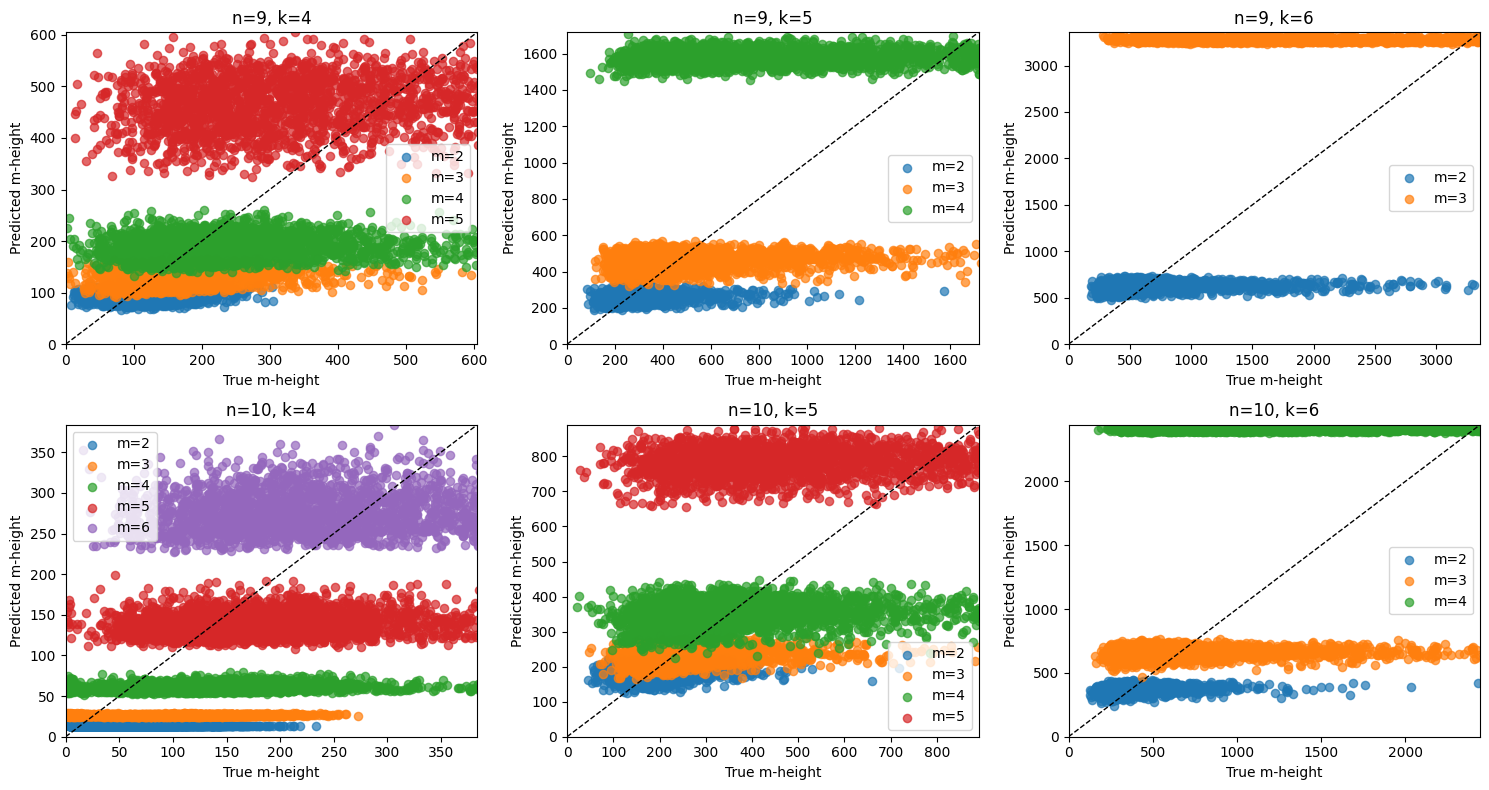

In [168]:
def plot_group(df, n_val, k_val, ax):
    subset = df[(df["n"] == n_val) & (df["k"] == k_val)]
    if subset.empty:
        return

    # 95 % filter
    subset["err"] = subset["pred_m"] - subset["true_m"]
    mu, sigma = subset["err"].mean(), subset["err"].std(ddof=1)
    z_value = 1.96
    lo, hi    = mu - z_value*sigma, mu + z_value*sigma
    subset    = subset[(subset["err"] >= lo) & (subset["err"] <= hi)]



    cmap   = plt.colormaps["tab10"]
    for idx, m_val in enumerate(sorted(subset["m"].unique())):
        df_m = subset[subset["m"] == m_val]
        ax.scatter(df_m["true_m"], df_m["pred_m"],
                   label=f"m={m_val}",
                   color=cmap(idx % 10), alpha=0.7, s=35)

    max_val = subset["pred_m"].max()
    ax.plot([0, max_val], [0, max_val], "--k", linewidth=1)
    ax.set_xlabel("True m‑height")
    ax.set_ylabel("Predicted m‑height")
    ax.set_title(f"n={n_val}, k={k_val}")
    ax.set_xlim(0, max_val)
    ax.set_ylim(0, max_val)
    ax.legend()

row_map = {0: 9, 1: 10}
col_map = {0: 4, 1: 5, 2: 6}

df = pd.DataFrame(total_records)
fig, axs = plt.subplots(2, 3, figsize=(15, 8))
for r in range(2):
    for c in range(3):
        plot_group(df, row_map[r], col_map[c], axs[r, c])
plt.tight_layout()
plt.show()



In [ ]:
df_err = pd.DataFrame(total_records)

def summarize(group):
    y_true = group['true'].values
    y_pred = group['pred'].values
    return pd.Series({
        'count':    len(group),
        'MAE':      mean_absolute_error(y_true, y_pred),
        'MAPE(%)':  100 * np.mean(np.abs((y_true - y_pred) / y_true)),
        'R2':       r2_score(y_true, y_pred),
        'log2-MSE': np.mean((np.log2(y_true) - np.log2(y_pred))**2)
    })

summary = df_err.groupby(['n','k','m']).apply(summarize).reset_index()
display(summary.sort_values('MAPE(%)', ascending=False))




# What was the test performance?

Test‐time evaluation was conducted using 100 samples per (n,k,m) configuration. Average Log₂‑MSE ranged from **0.27** (for low‑order settings, e.g. \(m=2\)) up to **7.0** (for more challenging cases such as \(10,4,3)\). Mean Absolute Error (MAE) varied from under **30** in the easiest regimes to over **1 400** when \(m\) grew large, and Mean Absolute Percentage Error (MAPE) spanned from **31 %** up to **800 %**. Coefficient of determination (R²) was positive but low (peak ~0.14) for simple settings and negative for high‑\(m\) configurations, indicating systematic under‑ or over‑prediction as the interference order increases. Overall, the model demonstrates strong performance on low‑order problems but declining accuracy for higher‑order \(m\) configurations.

In [ ]:
from google.colab import files
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

############################################
# Model Definition
############################################

class ResidualSE(nn.Module):
    def __init__(self, ch, squeeze=16):
        super().__init__()
        self.conv1 = nn.Conv2d(ch, ch, 3, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(ch)
        self.conv2 = nn.Conv2d(ch, ch, 3, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(ch)
        self.se    = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(ch, ch//squeeze, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(ch//squeeze, ch, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        att = self.se(out).view(out.size(0), out.size(1), 1, 1)
        return F.relu(out * att + x)

class MHeightResNet(nn.Module):
    def __init__(self, hidden_channels=128, mlp_dim=64, n_blocks=8):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(4, hidden_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(hidden_channels),
            nn.ReLU(inplace=True)
        )
        self.body = nn.Sequential(*[ResidualSE(hidden_channels) for _ in range(n_blocks)])
        self.pool = nn.AdaptiveAvgPool2d((1,1))
        self.mlp_nkm = nn.Sequential(
            nn.Linear(3, mlp_dim),
            nn.ReLU(),
            nn.Linear(mlp_dim, hidden_channels)
        )
        self.head = nn.Sequential(
            nn.Linear(hidden_channels*2, hidden_channels),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_channels, 1)
        )
    def forward(self, p_batch, nkm_batch):
        x = self.pool(self.body(self.stem(p_batch))).flatten(1)
        y = self.mlp_nkm(nkm_batch)
        out = self.head(torch.cat([x, y], dim=1))
        return 1.0 + F.relu(out)   # ensures output ≥ 1

############################################
# Load Trained Weights
############################################


print("Please upload your trained model file (mheight_model.pth):")
uploaded_model = files.upload()
if not uploaded_model:
    raise ValueError("No model file uploaded")
model_filename = list(uploaded_model.keys())[0]
print("Uploaded model file:", model_filename)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = MHeightResNet()
model.load_state_dict(torch.load("mheight_model_project2.pth", map_location=device))
model.to(device).eval()

############################################
# Prediction Function
############################################

def predict_m_heights(test_samples):
    """
    test_samples : list of (n, k, m, P)
      P is a numpy array shape (k, n-k)
    Returns a 1D torch.Tensor of predicted m‑heights.
    """
    pad_h, pad_w = 6, 6
    mats, nkms = [], []
    for n, k, m, P in test_samples:
        mat = np.zeros((pad_h, pad_w), dtype=np.float32)
        mat[:P.shape[0], :P.shape[1]] = P.astype(np.float32)
        mats.append(mat)
        nkms.append([n, k, m])
    P_tensor   = torch.tensor(mats)[..., None].permute(0,3,1,2).to(device)
    nkm_tensor = torch.tensor(nkms, dtype=torch.float32).to(device)
    with torch.no_grad():
        out = model(P_tensor, nkm_tensor)
    return out.flatten().cpu()

############################################
# Example Usage
############################################

print("\nPlease upload your test dataset file (test_samples.npy); each sample tuple (n, k, m, P):")
uploaded_data = files.upload()
if not uploaded_data:
    raise ValueError("No model file uploaded")
data_filename = list(uploaded_data.keys())[0]
print("Uploaded test dataset file:", data_filename)

test_samples = np.load(data_filename, allow_pickle=True)
print(f"Loaded {len(test_samples)} test samples.")

############################################
# Inference on Test Dataset
############################################
predicted_m_heights = []
pad_h, pad_w = 6, 6  # zero-padding P

with torch.no_grad():
    for sample in test_samples:
        n, k, m, P = sample
        padded_P = np.zeros((pad_h, pad_w), dtype=np.float32)
        real_h, real_w = P.shape
        padded_P[:real_h, :real_w] = P.astype(np.float32)

        p_tensor = torch.from_numpy(padded_P).unsqueeze(0).unsqueeze(0).to(device)
        nkm_tensor = torch.tensor([n, k, m], dtype=torch.float32).unsqueeze(0).to(device)

        prediction = model(p_tensor, nkm_tensor)
        predicted_m_heights.append(prediction.item())

predicted_tensor = torch.tensor(predicted_m_heights)
print("\nPredicted m-heights:")
print(predicted_tensor)

Trained model loaded successfully.
Synthetic test dataset saved as 'test_samples.npy'.
Loaded 5 test samples.

Predicted m-heights:
tensor([7.0115, 6.9087, 6.9889, 6.9924, 6.9798])
